Using device: cpu

Available keys in data: ['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train']

Loading 100 samples from oos_train
Loading 100 samples from oos_val
Loading 1000 samples from oos_test

Total samples: 23700
Total intents: 151
OOS samples found: 1200
  Train OOS: 100
  Val OOS: 100
  Test OOS: 1000

Filtered dataset size: 2850

Intent distribution (including OOS):
intent
calendar                 150
calendar_update          150
change_speed             150
change_volume            150
next_song                150
oos                     1200
play_music               150
shopping_list            150
shopping_list_update     150
smart_home               150
timer                    150
what_song                150
Name: count, dtype: int64

Class Balance Check:
Min samples: 150
Max samples: 1200
Mean samples: 237.5
OOS samples: 1200

Label Mapping:
0: calendar             ( 150 samples)
1: calendar_update      ( 150 samples)
2: change_speed         ( 150 samples)
3:

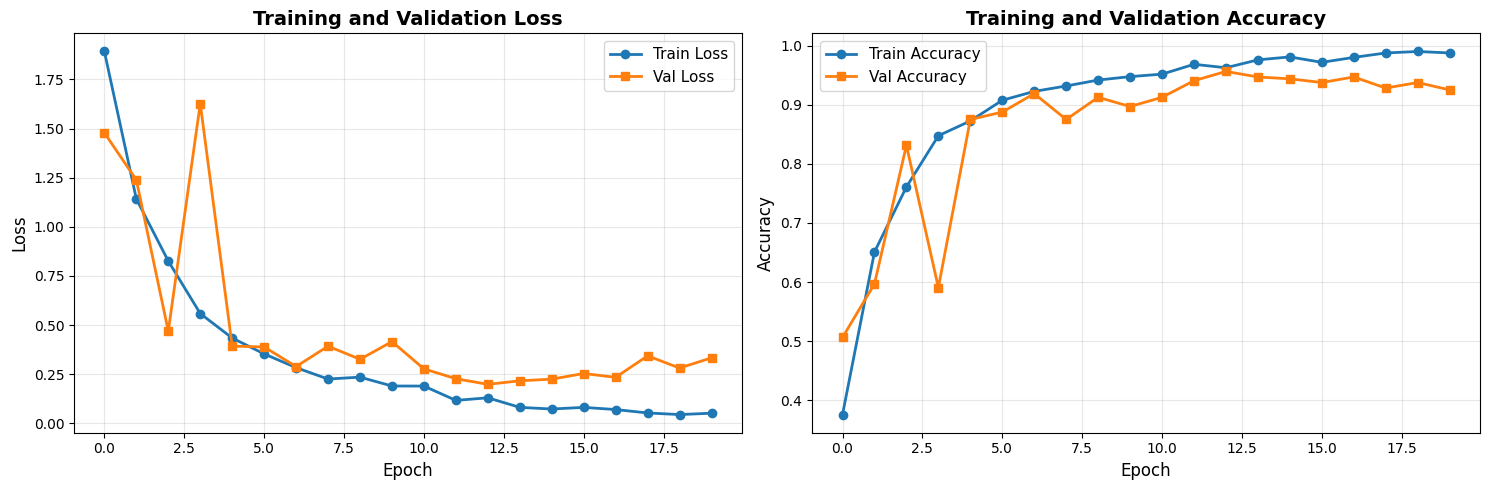

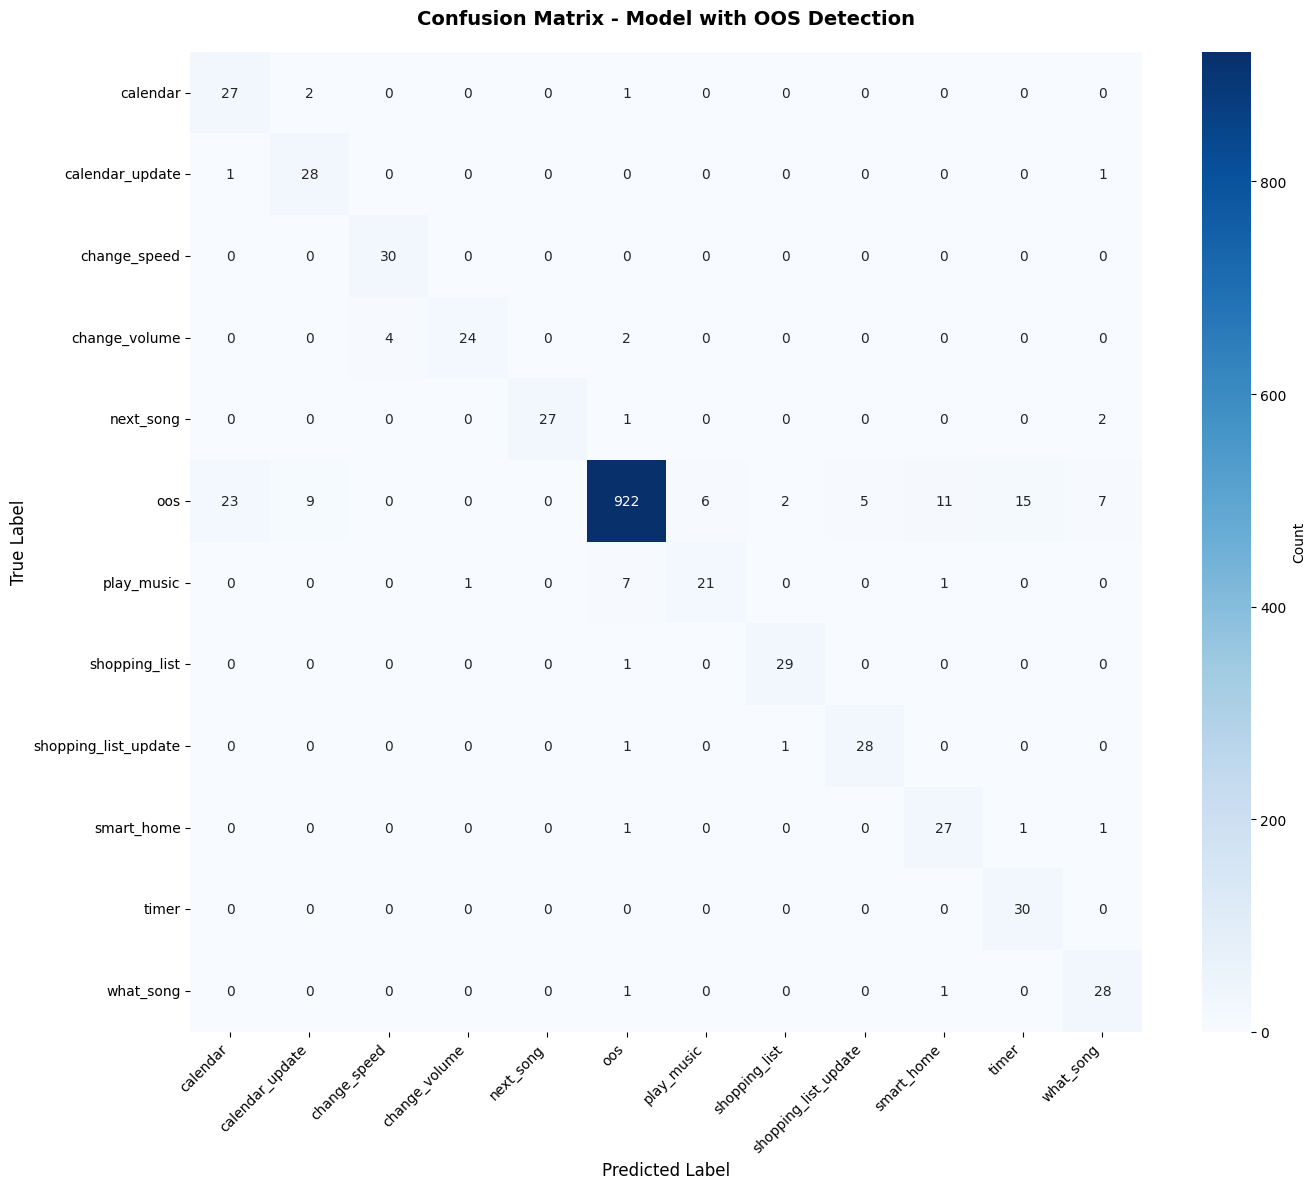

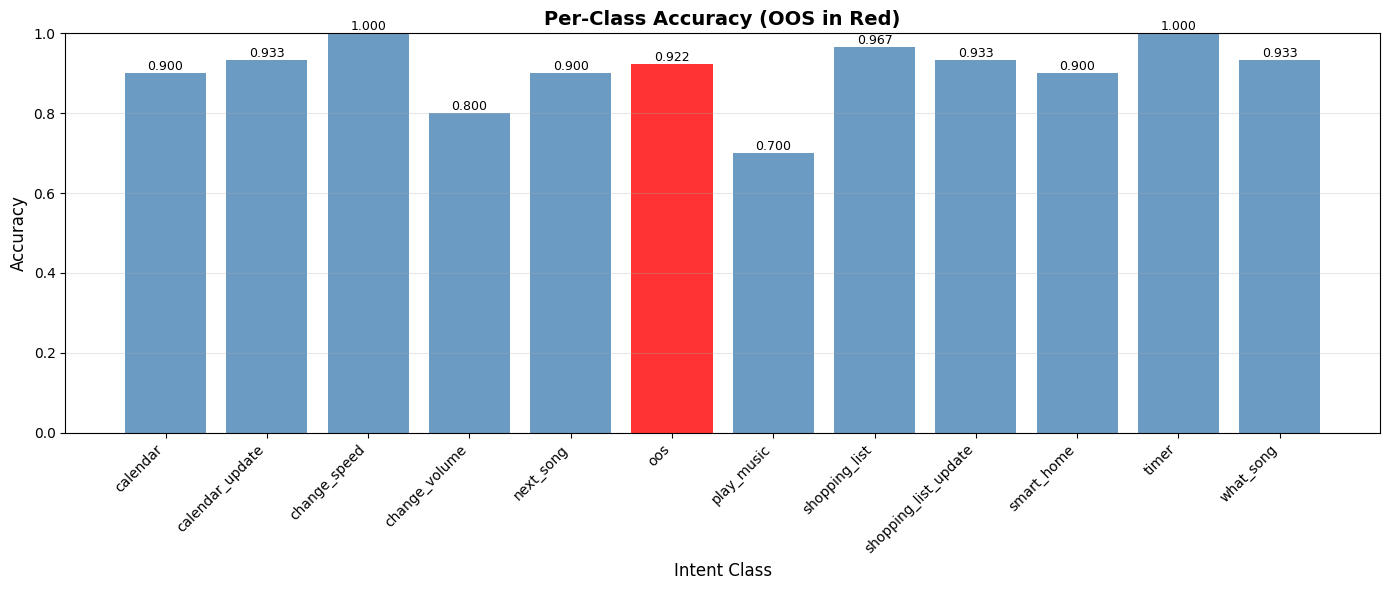


SAMPLE PREDICTIONS (INCLUDING OOS)

Text: Add milk to my shopping list
Predicted Intent: shopping_list_update
Confidence: 0.9951
OOS Confidence: 0.0000
Top 3 predictions:
  shopping_list_update: 0.9951
  shopping_list: 0.0037
  calendar_update: 0.0004

Text: Set an alarm for 7 AM
Predicted Intent: timer
Confidence: 0.9674
OOS Confidence: 0.0016
Top 3 predictions:
  timer: 0.9674
  calendar: 0.0228
  calendar_update: 0.0032

Text: Play some jazz music
Predicted Intent: play_music
Confidence: 0.9997
OOS Confidence: 0.0000
Top 3 predictions:
  play_music: 0.9997
  calendar: 0.0001
  next_song: 0.0001

Text: What's on my calendar today?
Predicted Intent: calendar
Confidence: 0.9990
OOS Confidence: 0.0002
Top 3 predictions:
  calendar: 0.9990
  calendar_update: 0.0006
  oos: 0.0002 ← OOS

Text: Turn off the living room lights
Predicted Intent: smart_home
Confidence: 0.9740
OOS Confidence: 0.0251
Top 3 predictions:
  smart_home: 0.9740
  oos: 0.0251 ← OOS
  change_volume: 0.0002

Text: Set 

In [7]:
# ============================================================================
# DEEP LEARNING INTENT CLASSIFIER (WITH OOS HANDLING)
# ============================================================================

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set random seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

# ============================================================================
# 1. LOAD AND PREPARE DATA
# ============================================================================

# Load data
DATA_FILE = "./data_full.json"

with open(DATA_FILE, 'r', encoding='utf-8') as f:
    data = json.load(f)

print("Available keys in data:", list(data.keys()))
print()

# Create DataFrame - Load both regular intents AND separate OOS data
records = []

# Load regular intents (train, val, test)
for split_name in ['train', 'val', 'test']:
    if split_name in data:
        for rec in data[split_name]:
            records.append({
                'split': split_name,
                'text': rec[0],
                'intent': rec[1]
            })

# Load OOS data from separate keys (oos_train, oos_val, oos_test)
for split_name in ['train', 'val', 'test']:
    oos_key = f'oos_{split_name}'
    if oos_key in data:
        print(f"Loading {len(data[oos_key])} samples from {oos_key}")
        for rec in data[oos_key]:
            records.append({
                'split': split_name,
                'text': rec[0],
                'intent': 'oos'  # Label all OOS data as 'oos'
            })

print()

df = pd.DataFrame(records)
print(f"Total samples: {len(df)}")
print(f"Total intents: {df['intent'].nunique()}")

# Check for OOS data
oos_count = (df['intent'] == 'oos').sum()
print(f"OOS samples found: {oos_count}")
print(f"  Train OOS: {((df['split']=='train') & (df['intent']=='oos')).sum()}")
print(f"  Val OOS: {((df['split']=='val') & (df['intent']=='oos')).sum()}")
print(f"  Test OOS: {((df['split']=='test') & (df['intent']=='oos')).sum()}")
print()

# ============================================================================
# 2. DEFINE YOUR 11 CUSTOM INTENTS + OOS (TOTAL: 12 CLASSES)
# ============================================================================

CUSTOM_INTENTS = [
   "play_music",
    "next_song",
    "what_song",
    "change_volume",
    "change_speed",
    "smart_home",
    "timer",
    "calendar",
    "calendar_update",
    "shopping_list",
    "shopping_list_update",
    "oos",
]

# Filter dataset to include custom intents + OOS
df_filtered = df[df['intent'].isin(CUSTOM_INTENTS)].copy()
print(f"Filtered dataset size: {len(df_filtered)}")
print(f"\nIntent distribution (including OOS):")
intent_dist = df_filtered['intent'].value_counts().sort_index()
print(intent_dist)
print()

# Check class balance
print("Class Balance Check:")
print(f"Min samples: {intent_dist.min()}")
print(f"Max samples: {intent_dist.max()}")
print(f"Mean samples: {intent_dist.mean():.1f}")
print(f"OOS samples: {intent_dist.get('oos', 0)}")
print()

# Encode labels
label_encoder = LabelEncoder()
df_filtered['label'] = label_encoder.fit_transform(df_filtered['intent'])

label_to_intent = dict(enumerate(label_encoder.classes_))
intent_to_label = {v: k for k, v in label_to_intent.items()}
num_classes = len(CUSTOM_INTENTS)

print("Label Mapping:")
for label, intent in label_to_intent.items():
    count = intent_dist.get(intent, 0)
    is_oos = " ← OUT-OF-SCOPE" if intent == 'oos' else ""
    print(f"{label}: {intent:20s} ({count:4d} samples){is_oos}")
print()

# Split data
train_df = df_filtered[df_filtered['split'] == 'train'].reset_index(drop=True)
val_df = df_filtered[df_filtered['split'] == 'val'].reset_index(drop=True)
test_df = df_filtered[df_filtered['split'] == 'test'].reset_index(drop=True)

print("="*60)
print("DATA SPLIT SUMMARY")
print("="*60)
print(f"Train: {len(train_df)} samples")
print(f"  - In-scope: {(train_df['intent']!='oos').sum()}")
print(f"  - OOS: {(train_df['intent']=='oos').sum()}")
print(f"\nValidation: {len(val_df)} samples")
print(f"  - In-scope: {(val_df['intent']!='oos').sum()}")
print(f"  - OOS: {(val_df['intent']=='oos').sum()}")
print(f"\nTest: {len(test_df)} samples")
print(f"  - In-scope: {(test_df['intent']!='oos').sum()}")
print(f"  - OOS: {(test_df['intent']=='oos').sum()}")
print("="*60)
print()

# ============================================================================
# 3. BUILD VOCABULARY FROM SCRATCH
# ============================================================================

class Vocabulary:
    def __init__(self, min_freq=1):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_freq = Counter()
        self.min_freq = min_freq

    def build_vocab(self, texts):
        # Count word frequencies
        for text in texts:
            words = text.lower().split()
            self.word_freq.update(words)

        # Add words that meet minimum frequency
        idx = 2
        for word, freq in self.word_freq.items():
            if freq >= self.min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

        print(f"Vocabulary size: {len(self.word2idx)}")

    def encode(self, text):
        words = text.lower().split()
        return [self.word2idx.get(word, self.word2idx['<UNK>']) for word in words]

    def decode(self, indices):
        return ' '.join([self.idx2word.get(idx, '<UNK>') for idx in indices])

# Build vocabulary
vocab = Vocabulary(min_freq=2)
vocab.build_vocab(train_df['text'].tolist())

# Encode texts
MAX_LEN = 50

def encode_texts(texts, vocab, max_len):
    encoded = []
    for text in texts:
        tokens = vocab.encode(text)
        if len(tokens) > max_len:
            tokens = tokens[:max_len]
        else:
            tokens = tokens + [0] * (max_len - len(tokens))
        encoded.append(tokens)
    return np.array(encoded)

X_train = encode_texts(train_df['text'].tolist(), vocab, MAX_LEN)
X_val = encode_texts(val_df['text'].tolist(), vocab, MAX_LEN)
X_test = encode_texts(test_df['text'].tolist(), vocab, MAX_LEN)

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}\n")

# ============================================================================
# 4. HANDLE CLASS IMBALANCE (IMPORTANT FOR OOS)
# ============================================================================

# Calculate class weights for handling imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("Class Weights (to handle imbalance):")
for i, weight in enumerate(class_weights):
    intent_name = label_to_intent[i]
    is_oos = " ← OOS class (higher weight if imbalanced)" if intent_name == 'oos' else ""
    print(f"{intent_name:20s}: {weight:.4f}{is_oos}")
print()

# ============================================================================
# 5. DEFINE DEEP LEARNING MODEL FROM SCRATCH
# ============================================================================

class IntentClassifierWithOOS(nn.Module):
    """
    Custom Deep Learning Architecture with OOS Detection:
    - Embedding Layer (learned from scratch)
    - Bidirectional LSTM
    - Attention Mechanism
    - Fully Connected Layers with Dropout
    - Optimized for OOS detection
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers=2, dropout=0.5):
        super(IntentClassifierWithOOS, self).__init__()

        # Embedding layer (learned from scratch)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim // 2)

    def attention_net(self, lstm_output):
        """
        Attention mechanism to focus on important parts of the sequence
        """
        attention_weights = torch.tanh(self.attention(lstm_output))
        attention_weights = torch.softmax(attention_weights, dim=1)
        weighted_output = lstm_output * attention_weights
        return torch.sum(weighted_output, dim=1)

    def forward(self, text):
        # Embedding
        embedded = self.embedding(text)
        embedded = self.dropout(embedded)

        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Apply attention
        attended = self.attention_net(lstm_out)
        attended = self.layer_norm(attended)

        # Fully connected layers with dropout and batch norm
        x = F.relu(self.fc1(attended))
        x = self.batch_norm1(x)
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.batch_norm2(x)
        x = self.dropout(x)

        output = self.fc3(x)

        return output

# ============================================================================
# 6. INITIALIZE MODEL AND TRAINING SETUP
# ============================================================================

# Hyperparameters
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
N_LAYERS = 2
DROPOUT = 0.5
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 30

# Initialize model
model = IntentClassifierWithOOS(
    vocab_size=len(vocab.word2idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=num_classes,
    n_layers=N_LAYERS,
    dropout=DROPOUT
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("="*60)
print("MODEL ARCHITECTURE (WITH OOS DETECTION)")
print("="*60)
print(model)
print("="*60)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("="*60)
print()

# Loss with class weights (important for OOS!)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler WITHOUT verbose parameter
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3
)

# Create DataLoaders
train_data = TensorDataset(torch.LongTensor(X_train), torch.LongTensor(y_train))
val_data = TensorDataset(torch.LongTensor(X_val), torch.LongTensor(y_val))
test_data = TensorDataset(torch.LongTensor(X_test), torch.LongTensor(y_test))

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

# ============================================================================
# 7. TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), correct / total, predictions, true_labels

# ============================================================================
# 8. TRAIN THE MODEL
# ============================================================================

print("Starting training...\n")

train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_acc = 0
patience = 7
patience_counter = 0

for epoch in range(EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validate
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Update learning rate (no verbose output)
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_acc)
    new_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1:02d}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    # Show LR change if it happened
    if new_lr != old_lr:
        print(f"  Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_with_oos.pt')
        print(f"  ✓ New best model saved! (Val Acc: {val_acc:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⚠ Early stopping triggered after {epoch+1} epochs")
            break
    print()

print("Training complete!\n")

# ============================================================================
# 9. EVALUATE ON TEST SET
# ============================================================================

# Load best model
model.load_state_dict(torch.load('best_model_with_oos.pt'))

test_loss, test_acc, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

print("="*60)
print("TEST SET RESULTS (INCLUDING OOS)")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("="*60)
print()

# Calculate OOS-specific metrics
oos_label = intent_to_label['oos']
oos_mask = np.array(test_labels) == oos_label
oos_predictions = np.array(test_preds)[oos_mask]
oos_true = np.array(test_labels)[oos_mask]

# Calculate in-scope accuracy
in_scope_mask = np.array(test_labels) != oos_label
in_scope_predictions = np.array(test_preds)[in_scope_mask]
in_scope_true = np.array(test_labels)[in_scope_mask]

if len(oos_true) > 0:
    oos_accuracy = (oos_predictions == oos_label).sum() / len(oos_true)
    print(f"OOS Detection Accuracy: {oos_accuracy:.4f}")
    print(f"OOS Samples in Test: {len(oos_true)}")

if len(in_scope_true) > 0:
    in_scope_accuracy = (in_scope_predictions == in_scope_true).sum() / len(in_scope_true)
    print(f"In-Scope Accuracy: {in_scope_accuracy:.4f}")
    print(f"In-Scope Samples in Test: {len(in_scope_true)}")
print()

# Classification report
print("Classification Report:")
print("="*60)
print(classification_report(
    test_labels,
    test_preds,
    target_names=[label_to_intent[i] for i in range(num_classes)],
    digits=4
))

# ============================================================================
# 10. VISUALIZATIONS
# ============================================================================

# Training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss', marker='o', linewidth=2)
ax1.plot(val_losses, label='Val Loss', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(train_accs, label='Train Accuracy', marker='o', linewidth=2)
ax2.plot(val_accs, label='Val Accuracy', marker='s', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[label_to_intent[i] for i in range(num_classes)],
    yticklabels=[label_to_intent[i] for i in range(num_classes)],
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Model with OOS Detection',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy with OOS highlighted
class_accuracies = []
for i in range(num_classes):
    mask = np.array(test_labels) == i
    if mask.sum() > 0:
        acc = (np.array(test_preds)[mask] == i).sum() / mask.sum()
        class_accuracies.append(acc)
    else:
        class_accuracies.append(0)

plt.figure(figsize=(14, 6))
colors = ['red' if label_to_intent[i] == 'oos' else 'steelblue'
          for i in range(num_classes)]
bars = plt.bar(range(num_classes), class_accuracies, color=colors, alpha=0.8)
plt.xlabel('Intent Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Class Accuracy (OOS in Red)', fontsize=14, fontweight='bold')
plt.xticks(range(num_classes), [label_to_intent[i] for i in range(num_classes)],
           rotation=45, ha='right')
plt.ylim([0, 1.0])
plt.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# ============================================================================
# 11. INFERENCE FUNCTION WITH OOS DETECTION
# ============================================================================

def predict_intent(text, model, vocab, label_encoder, device, max_len=50,
                   oos_threshold=0.5):
    """
    Predict intent for a given text with OOS detection

    Args:
        text: Input text string
        model: Trained model
        vocab: Vocabulary object
        label_encoder: Label encoder
        device: Device to run inference on
        max_len: Maximum sequence length
        oos_threshold: Confidence threshold for OOS detection

    Returns:
        Dictionary with predicted intent, confidence, OOS flag, and all probabilities
    """
    model.eval()

    # Encode text
    tokens = vocab.encode(text)
    if len(tokens) > max_len:
        tokens = tokens[:max_len]
    else:
        tokens = tokens + [0] * (max_len - len(tokens))

    input_tensor = torch.LongTensor([tokens]).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        prediction = np.argmax(probs)
        confidence = probs[prediction]

    intent = label_encoder.inverse_transform([prediction])[0]

    # Get all probabilities
    all_probs = {
        label_encoder.inverse_transform([i])[0]: float(prob)
        for i, prob in enumerate(probs)
    }

    # Check if OOS
    is_oos = intent == 'oos'
    oos_confidence = all_probs.get('oos', 0.0)

    # Determine if we should flag as uncertain/OOS
    max_in_scope_prob = max([p for intent_name, p in all_probs.items()
                              if intent_name != 'oos'])

    return {
        'intent': intent,
        'confidence': float(confidence),
        'is_oos': is_oos,
        'oos_confidence': float(oos_confidence),
        'max_in_scope_confidence': float(max_in_scope_prob),
        'all_probabilities': all_probs,
        'needs_review': confidence < oos_threshold  # Flag low confidence predictions
    }

# ============================================================================
# 12. TEST PREDICTIONS WITH OOS
# ============================================================================

print("\n" + "="*60)
print("SAMPLE PREDICTIONS (INCLUDING OOS)")
print("="*60)

test_texts = [
    # In-scope queries for your custom intents
    "Add milk to my shopping list",
    "Set an alarm for 7 AM",
    "Play some jazz music",
    "What's on my calendar today?",
    "Turn off the living room lights",
    "Set a timer for 10 minutes",
    "Where is my phone?",
    "Update my calendar for tomorrow",
    "Remove eggs from shopping list",
    "Increase the volume",
    "Slow down the playback speed",

    # Potential OOS queries
    "What's the weather today?",
    "Tell me a joke",
    "What's 25 times 34?",
    "Who won the game last night?",
    "Book a flight to Paris",
]

for text in test_texts:
    result = predict_intent(text, model, vocab, label_encoder, device)

    print(f"\nText: {text}")
    print(f"Predicted Intent: {result['intent']}")
    print(f"Confidence: {result['confidence']:.4f}")

    if result['is_oos']:
        print("OUT-OF-SCOPE detected!")
    elif result['needs_review']:
        print("Low confidence - needs review")

    print(f"OOS Confidence: {result['oos_confidence']:.4f}")

    # Show top 3 predictions
    sorted_probs = sorted(result['all_probabilities'].items(),
                          key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 predictions:")
    for intent_name, prob in sorted_probs:
        oos_marker = " ← OOS" if intent_name == 'oos' else ""
        print(f"  {intent_name}: {prob:.4f}{oos_marker}")

print("\n" + "="*60)
print("✓ Training and evaluation complete with OOS detection!")
print("="*60)